In [1]:
from tensorflow.python.client import device_lib
import tensorflow as tf
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

In [2]:
import tensorflow as tf

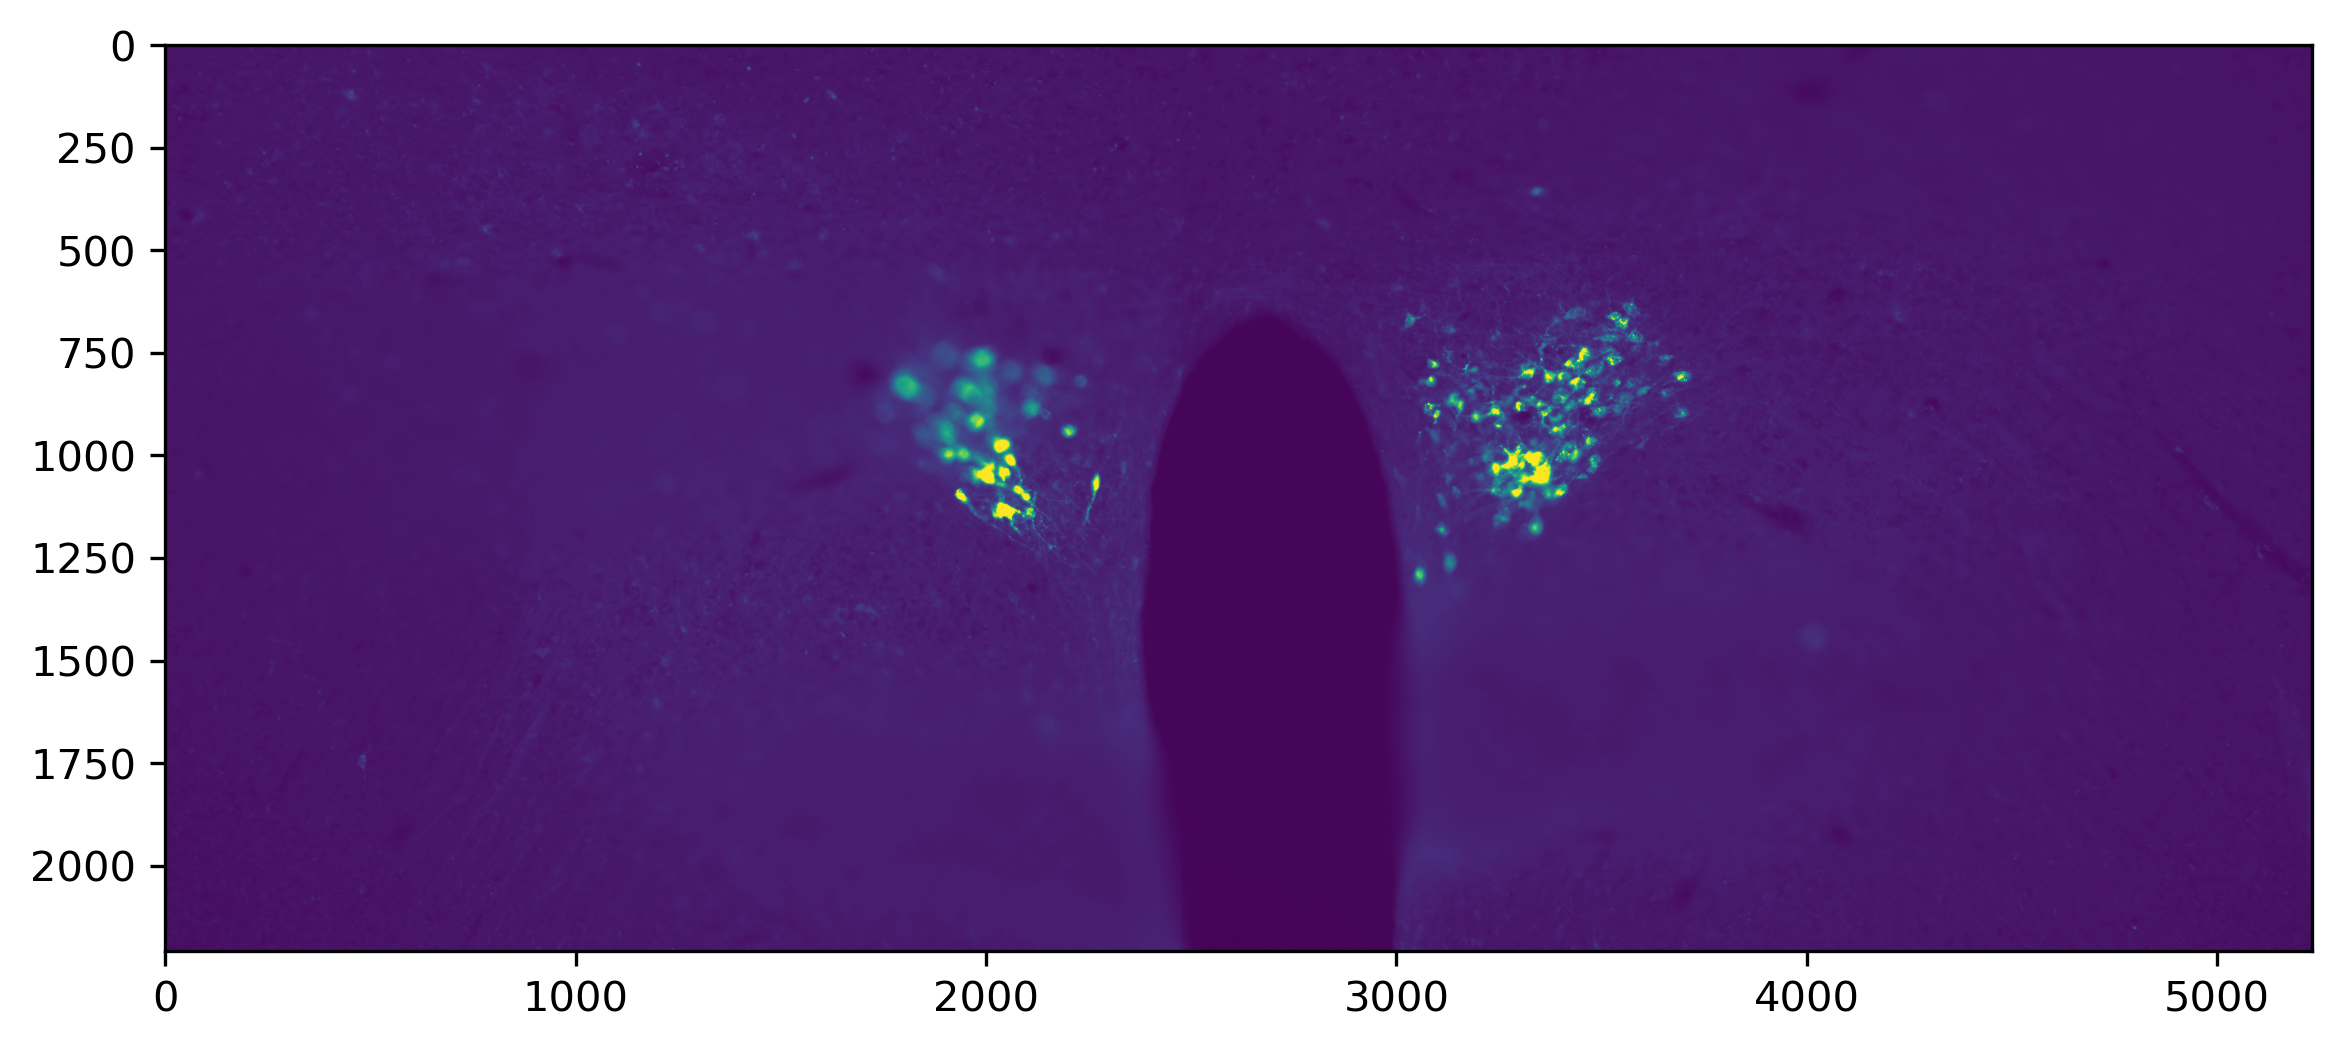

In [14]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils
import tensorflow as tf

# REPLACE FILES WITH YOUR IMAGE PATHS
# files = ['img0.tif', 'img1.tif']\
img_path = r'\\172.25.144.34\LabCommon\Ken\data\Confocal\Ken\Esr2_Gi\m176\Image sequences\r_stack'
out_root = r'\\172.25.144.34\Apotome\Ken\2020\Esr2-Gi DREADD\Gi_expression\images_out'
filename = 'Experiment-196-Image Export-05_s10c2'

out_path = os.path.join(out_root,filename)
tiles_path = os.path.join(out_root,filename,'tiles')

# create the paths
for x in [out_root,out_path,tiles_path]:
    if not os.path.exists(x):
        os.mkdir(x)

channel = 0
img = skimage.io.imread(os.path.join(img_path,filename + '.tif'))
if len(img.shape) ==3:
    img = img[:,:,channel]
plt.figure(figsize=(12,4))
plt.imshow(img)
#plt.close()

In [15]:
def split_image(image3, tile_size):
    image_shape = np.shape(image3)
    tile_rows = np.reshape(image3, [image_shape[0], -1, tile_size[1]])
    serial_tiles = np.transpose(tile_rows, [1, 0, 2])
    return np.reshape(serial_tiles, [-1, tile_size[1], tile_size[0]])
def pad_image_to_tile_multiple(image3, tile_size, padding="CONSTANT"):
    out = (np.array(image3.shape) // tile_size + 1 )* tile_size - np.array(image3.shape) 
    x = np.pad(image3, ((0,out[0]), (0,out[1])), 'constant',constant_values = (0,0))
    return x
def unsplit_image(tiles4, image_shape):
    tile_width = np.array(tiles4).shape[1]
    serialized_tiles = np.reshape(tiles4, [-1, image_shape[0], tile_width])
    rowwise_tiles = np.transpose(serialized_tiles, [1, 0, 2])
    return np.reshape(rowwise_tiles, [image_shape[0], image_shape[1]])
def unsplit_image_4d(tiles4, image_shape):
    tile_width = np.array(tiles4).shape[1]
    serialized_tiles = np.reshape(np.array(tiles4), [-1, image_shape[0], tile_width,image_shape[2]])
    rowwise_tiles = np.transpose(serialized_tiles, [1, 0, 2,3])
    return np.reshape(rowwise_tiles, [image_shape[0], image_shape[1],image_shape[2]])

In [16]:
tile_size = [500, 500]
image = pad_image_to_tile_multiple(img,tile_size)
pad_shape = image.shape
img_tiles = split_image(image,tile_size)
img_rescue = unsplit_image(img_tiles, np.shape(image))


In [17]:
# RUN CELLPOSE

from cellpose import models

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus
diameter =30
# or if you have different types of channels in each image
#channels = [[2,3], [0,0], [0,0]]


# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images
masks, flows, styles, diams = model.eval(img_tiles, diameter=diameter, channels=channels)

>>>> using GPU
processing 55 images


 25%|████████████████████▊                                                             | 14/55 [00:20<00:57,  1.41s/it]D:\ProgramData\Anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\ProgramData\Anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [01:19<00:00,  1.44s/it]


In [18]:
mask = unsplit_image(masks, pad_shape)
flow_0 = [flow[0] for flow in flows]
flow = unsplit_image_4d(flow_0, [pad_shape[0],pad_shape[1],3])
image = image[0:img.shape[0], 0:img.shape[1]]
mask = mask[0:img.shape[0], 0:img.shape[1]]
flow = flow[0:img.shape[0], 0:img.shape[1],:]
skimage.io.imsave(os.path.join(out_path,filename +'_mask.tif'),mask.astype('uint8'))
skimage.io.imsave(os.path.join(out_path,filename +'_flow.tif'),flow.astype('uint8'))

# get info of cell probability
flow_1 = [flow[1][1] for flow in flows]
flow_1_whole = unsplit_image(flow_1,pad_shape)
flow_1_whole = flow_1_whole[0:img.shape[0], 0:img.shape[1]]

flow_2 = [flow[2] for flow in flows]


D:\ProgramData\Anaconda3\envs\cellpose\lib\site-packages\ipykernel_launcher.py:7: UserWarning: \\172.25.144.34\Apotome\Ken\2020\Esr2-Gi DREADD\Gi_expression\images_out\Experiment-196-Image Export-05_s10c2\Experiment-196-Image Export-05_s10c2_mask.tif is a low contrast image
  import sys


In [19]:
flow_1_whole

array([[ 1.56084701e-01,  1.82055742e-01,  1.59289077e-01, ...,
        -2.28908956e-02,  1.87987145e-02,  3.77922691e-03],
       [ 5.11286497e-01,  6.23882174e-01,  3.93680513e-01, ...,
        -1.15979895e-01,  9.92684439e-03,  7.03620818e-03],
       [ 5.28936028e-01,  6.04247808e-01,  3.89949739e-01, ...,
        -1.38742954e-01,  2.57443311e-03,  6.13985816e-04],
       ...,
       [ 1.29986811e+00,  1.52846622e+00,  1.04107583e+00, ...,
        -1.53571844e-01, -1.53547358e-02,  8.70335568e-03],
       [ 1.20479691e+00,  1.45838988e+00,  1.02531838e+00, ...,
        -1.31512120e-01, -3.14676645e-03,  9.69610270e-03],
       [ 3.81192863e-01,  6.23384476e-01,  4.06441092e-01, ...,
        -4.43933718e-02,  7.99631700e-03,  8.25837068e-03]], dtype=float32)

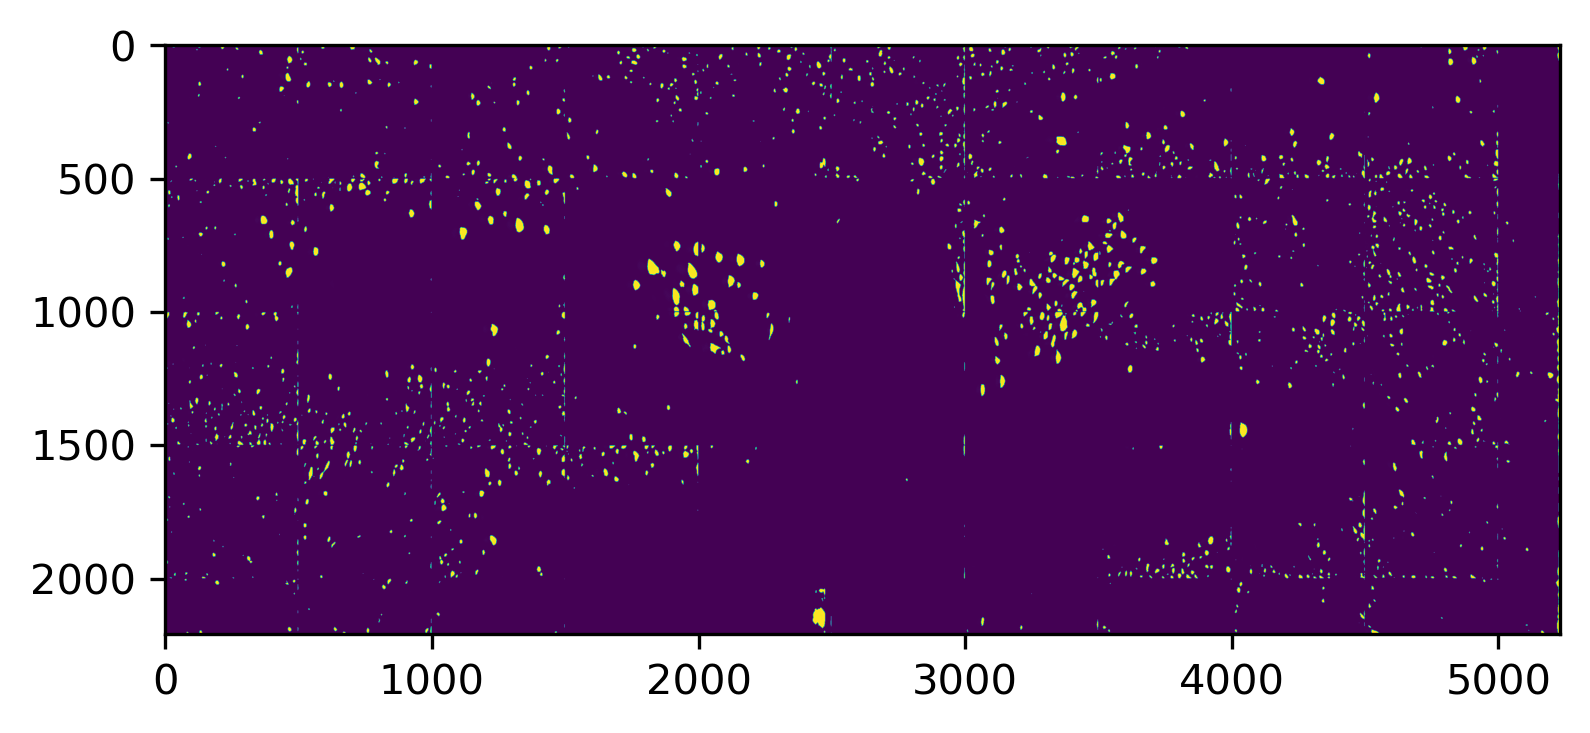

In [20]:
plt.imshow(flow_1_whole.astype('uint8'))

In [21]:
# create matrix of cell probability based on threshold
from skimage.feature import peak_local_max

threshold = 3.5
xy = peak_local_max(flow_1_whole, min_distance=2,threshold_abs=threshold)
temp_cell_prob  = np.zeros(flow_1_whole.shape)
temp_cell_prob[xy[:,0],xy[:,1]] = 255
#plt.imshow(temp_cell_prob.astype('uint8'))

skimage.io.imsave(os.path.join(out_path,filename +'_cell_prob.tif'),temp_cell_prob.astype('uint8'))


#temp  = temp_cell_prob[60:,52:]
#temp = np.pad(temp,((0,60),(0,52)),'constant', constant_values=(0,0))
#skimage.io.imsave(os.path.join(out_path,filename +'_cell_prob_2.tif'),temp.astype('uint8'))

import pandas as pd
df = pd.DataFrame(xy,columns = ['X','Y'])
df.to_csv(os.path.join(out_path,filename+'_cell_prob.csv'),index = False)

D:\ProgramData\Anaconda3\envs\cellpose\lib\site-packages\ipykernel_launcher.py:10: UserWarning: \\172.25.144.34\Apotome\Ken\2020\Esr2-Gi DREADD\Gi_expression\images_out\Experiment-196-Image Export-05_s10c2\Experiment-196-Image Export-05_s10c2_cell_prob.tif is a low contrast image
  # Remove the CWD from sys.path while we load stuff.


In [22]:
import pickle

with open(os.path.join(out_path,filename+"mask.pickle"), "wb") as f:
    pickle.dump(masks, f)

with open(os.path.join(out_path,filename+"flows.pickle"), "wb") as f:
    pickle.dump(flows, f)

with open(os.path.join(out_path,filename+"styles.pickle"), "wb") as f:
    pickle.dump(styles, f)

with open(os.path.join(out_path,filename+"diams.pickle"), "wb") as f:
    pickle.dump(diams, f)



In [23]:
from cellpose import plot

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, mask, flow, channels=channels)
plt.tight_layout()
#plt.show()
plt.savefig(os.path.join(out_path,filename + '_summary_whole.png'),format = 'png',dpi = 216)
plt.close()

In [24]:
# DISPLAY RESULTS
from cellpose import plot

for idx in range(0,img_tiles.shape[0]):
    maski = masks[idx]
    flowi = flow_0[idx]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, img_tiles[idx], maski, flowi, channels=channels)
    plt.tight_layout()
    #plt.show()
    plt.savefig(os.path.join(tiles_path,filename + '_summary_' + str(idx) +'_crop.png'),format = 'png',dpi = 216)
    plt.close()

In [25]:
import pickle
masks = pickle.load( open(os.path.join(out_path,filename + 'mask.pickle'), "rb" ) )
flows = pickle.load( open(os.path.join(out_path,filename + 'flows.pickle'), "rb" ) )
styles = pickle.load( open(os.path.join(out_path,filename + 'styles.pickle'), "rb" ) )
diams = pickle.load( open(os.path.join(out_path,filename + 'diams.pickle'), "rb" ) )
mask = skimage.io.imread(os.path.join(out_path,filename +'_mask.tif'))
flow = skimage.io.imread(os.path.join(out_path,filename +'_flow.tif'))